In [76]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import average_precision_score, precision_recall_curve, auc, recall_score, confusion_matrix, precision_score
import pandas as pd
import pickle
from tensorflow import keras
import joblib
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

In [2]:
def multiclass_prc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return average_precision_score(y_test, y_pred, average=average)

In [8]:
test_data = pd.read_csv("../affectations/test_data_labelled.tsv", sep="\t")

In [11]:
model_dico = {'resampled_model': [True], 'random_forest_recall': [False]}
scaler = pickle.load(open('../detect/parameters/scaler.pkl', 'rb'))
for model_type in model_dico:
    if model_dico[model_type][0]:
        model_dico[model_type].append(keras.models.load_model('../detect/parameters/{}'.format(model_type)))
    else:
        model_dico[model_type].append(joblib.load('../detect/parameters/{}.pkl'.format(model_type)))

2022-09-27 00:26:22.479557: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
get_value = lambda x: 1 if x>0.5 else 0

In [39]:
for type_model in model_dico:
    to_process_df = test_data[['cat', 'wage', 'expenses', 'estate']]
    to_process_df = np.array(to_process_df)
    if model_dico[type_model][0]:
        to_predict = scaler.transform(to_process_df)
        result = model_dico[type_model][1].predict(to_predict)
    else:
        to_predict = pd.DataFrame(to_process_df, columns=['cat', 'wage', 'Log expenses', 'Log estate'])
        result = model_dico[type_model][1].predict(to_predict)
    test_data['result_{}'.format(type_model)] = result

1245/1245 [==============================] - 2s 1ms/step


In [50]:
performance_list = []
for i in range(6):
    y_pred_i_resampled = test_data.loc[test_data['cat']==i]['result_resampled_model'].to_numpy()
    y_pred_i_conv = [get_value(elem) for elem in y_pred_i_resampled]
    y_pred_i_random = test_data.loc[test_data['cat']==i]['result_random_forest_recall'].to_numpy()
    y_true_i = test_data.loc[test_data['cat']==i]['is_fraudster'].to_numpy()
    performance_list.append([i, average_precision_score(y_true_i, y_pred_i_resampled),
                             multiclass_prc_auc_score(y_true_i, y_pred_i_random),
                             recall_score(y_true_i, y_pred_i_conv),
                             recall_score(y_true_i, y_pred_i_random),
                             precision_score(y_true_i, y_pred_i_conv),
                             precision_score(y_true_i, y_pred_i_random)])
y_pred_resampled = test_data['result_resampled_model'].to_numpy()
y_pred_conv = [get_value(elem) for elem in y_pred_resampled]
y_pred_random = test_data['result_random_forest_recall'].to_numpy()
y_true = test_data['is_fraudster'].to_numpy()
performance_list.append(['all', average_precision_score(y_true, y_pred_resampled),
                         multiclass_prc_auc_score(y_true, y_pred_random), 
                         recall_score(y_true, y_pred_conv),
                         recall_score(y_true, y_pred_random),
                         precision_score(y_true, y_pred_conv),
                         precision_score(y_true, y_pred_random)])
pd.DataFrame(performance_list, columns=['cat', 'PRC_resampled',
                                        'PRC_random_forest_recall',
                                        'Recall_resampled',
                                        'Recall_random_forest_recall',
                                        'Precision_resampled',
                                        'Precison_random_forest_recall'])

cat  PRC_resampled  PRC_random_forest_recall  Recall_resampled  \
0    0       0.777647                  0.852304          0.929688   
1    1       0.686938                  0.866766          0.974910   
2    2       0.662897                  0.858261          0.997506   
3    3       0.765581                  0.856620          1.000000   
4    4       0.680769                  0.822023          0.857724   
5    5       0.115067                  0.660183          1.000000   
6  all       0.678366                  0.851110          0.958674   

   Recall_random_forest_recall  Precision_resampled  \
0                     0.878906             0.528302   
1                     0.919355             0.338098   
2                     0.877805             0.346620   
3                     0.899705             0.319510   
4                     0.882114             0.457701   
5                     0.840000             0.092251   
6                     0.892840             0.365585   

   Precison_random_forest_recall  
0                       0.961538  
1                       0.937843  
2                       0.972376  
3                       0.947205  
4                       0.919492  
5                       0.777778  
6                       0.946993

In [51]:
to_predict_proba = pd.DataFrame(to_process_df, columns=['cat', 'wage', 'Log expenses', 'Log estate'])
result = model_dico[type_model][1].predict_proba(to_predict)[:,1]
precision, recall, threshold = precision_recall_curve(y_true, result)

In [93]:
distance_list = np.array([sqrt(precision[i]**2+recall[i]**2) for i in range(len(precision))])
np.where(distance_list == max(distance_list))

(array([615]),)

Text(0, 0.5, 'Recall')

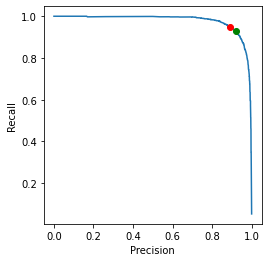

In [94]:
_, ax = plt.subplots()
ax.set_box_aspect(1)
plt.plot(recall, precision)
plt.plot(recall[615], precision[615], marker='o', color='green')
plt.plot(recall[694], precision[694], marker='o', color='red')
plt.xlabel("Precision")
plt.ylabel("Recall")

In [117]:
print(threshold[615], precision[615], recall[615])
print(threshold[694], precision[694], recall[694])
print(threshold[874], precision[874], recall[874])
print(threshold[1123], precision[1123], recall[1123])

0.42333333333333334 0.9300291545189504 0.9197501201345507
0.5016666666666667 0.9469928644240571 0.8928399807784719
0.7 0.9828605200945626 0.7991350312349832
0.9 0.9968253968253968 0.6035559827006247
